# Face Recognition Using Eigenfaces

Paper

1. Read dataset, calculate the mean face

2. Calculate covariance matrix

3. Select top k eigenvalues and eigenvectors

4. Calculate Euclidean distance

5. Classification, metrics, confusion matrix (Recall, Precision)

6. Reconstruct eigenfaces for visualization

7. Determine a new image has face or not, threshold

8. Determine a new image is known or unknown, threshold

9. Recognize test images from internet

(Optional) Real-time recogntion

1. Detection: Open-CV

2. Dimension Reduction: Fishfaces, LDA


In [1]:
import sys
sys.path.append('../src')

from pca import *
from utils import *


In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


In [3]:
# Only use people with more than 70 images, default resize=0.5
lfw_people = fetch_lfw_people(
    data_home="../data",
    min_faces_per_person=70,
    resize=1)
n_samples, h, w = lfw_people.images.shape

# Use the 1-D pixels as features, positions info is ignored
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("#Samples:", n_samples)
print("#Features Dimention:", n_features)
print("#Classes:", n_classes)

# X: (N x d), N: number of samples, d: feature dimention
print("X shape (N, d):", X.shape)
print(f"Image h, w: {h}, {w}")


#Samples: 1288
#Features Dimention: 11750
#Classes: 7
X shape (N, d): (1288, 11750)
Image h, w: 125, 94


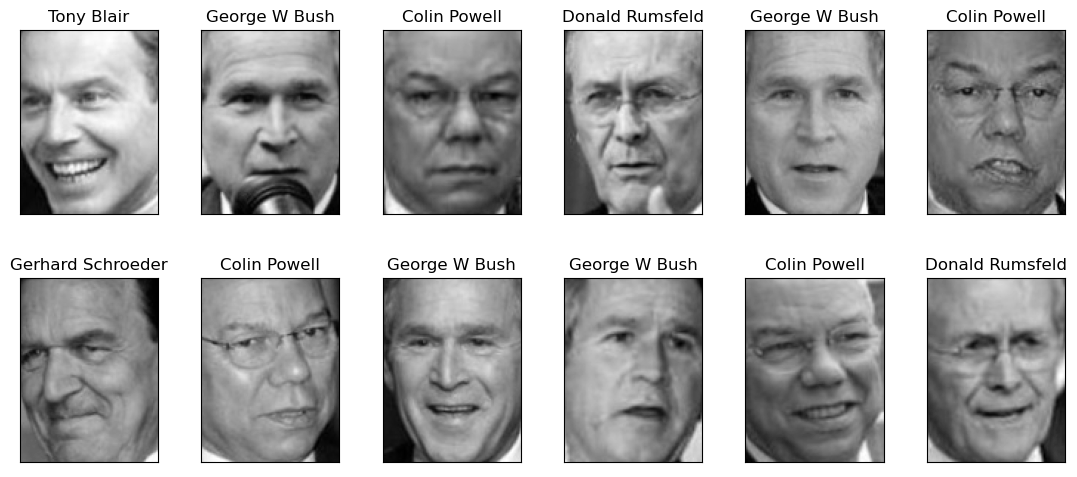

In [4]:
np.random.seed(0)
idx = np.random.randint(0, n_samples, 12)
images = lfw_people.images[idx]
plot_gallery(images, target_names[y[idx]], n_row=2, n_col=6)

Mean face shape: (11750,)


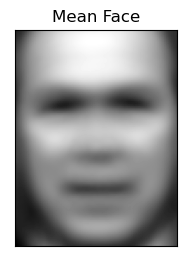

In [5]:
mean = mean_face(X)
mean1 = mean
print("Mean face shape:", mean.shape)
plot_gallery([mean.reshape(h, w)], ["Mean Face"], n_row=1, n_col=1)


In [6]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
mean = mean_face(X)

cov = cov_matrix(X, mean)
is_symmetric = np.allclose(cov, cov.T)
print("Covariance matrix is symmetric", is_symmetric)
print("Covariance matrix shape:", cov.shape)
print(cov[0][:20])


Covariance matrix is symmetric True
Covariance matrix shape: (1288, 1288)
[ 5.5100760e+00 -7.7027625e-01  2.2901322e-01  5.0200492e-02
 -2.6315922e-01 -1.9277444e+00 -4.6875706e-01  1.9554649e-01
 -1.8894970e+00 -8.6652637e-01 -1.4105459e+00 -2.4648106e+00
  1.1927737e+00 -6.6733450e-02  1.1190951e+00 -5.3100133e-01
  2.0085719e-01  4.6073213e-01  4.8499433e-03  8.5156053e-01]


In [7]:
eigval, eigvec = eigen(X, mean)
print("Eigenvalues shape:", eigval.shape)
print("Eigenvectors shape:", eigvec.shape)

eigface, weights = PCA(X, mean)
print("Eigenfaces shape:", eigface.shape)
print("Weights shape:", weights.shape)


Eigenvalues shape: (1288,)
Eigenvectors shape: (11750, 1288)
Eigenfaces shape: (11750, 150)
Weights shape: (1288, 150)


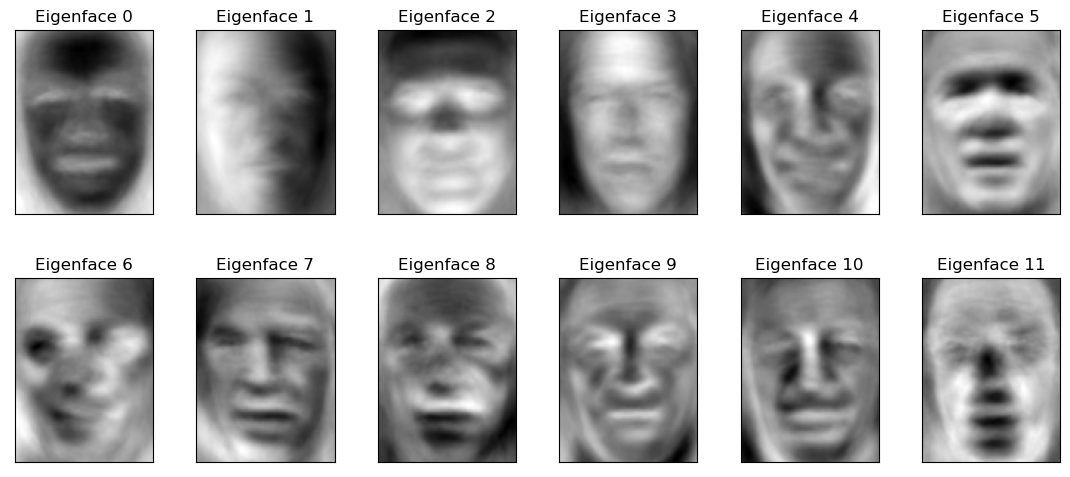

In [8]:
# Visualization of principal components
images = eigface[:, :12].T.reshape(-1, h, w)
plot_gallery(images, ["Eigenface %d" % i for i in range(12)], n_row=2, n_col=6)


In [9]:
proj = project(X, mean, eigface)
print("Projected shape:", proj.shape)
dist = euclidean(proj, weights)
print("Euclidean distance shape:", dist.shape)


Projected shape: (1288, 150)
Euclidean distance shape: (1288, 1288)


                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.38      0.36        13
     Colin Powell       0.64      0.58      0.61        60
  Donald Rumsfeld       0.45      0.56      0.50        27
    George W Bush       0.74      0.69      0.71       146
Gerhard Schroeder       0.37      0.40      0.38        25
      Hugo Chavez       0.50      0.33      0.40        15
       Tony Blair       0.36      0.44      0.40        36

         accuracy                           0.58       322
        macro avg       0.48      0.48      0.48       322
     weighted avg       0.60      0.58      0.59       322



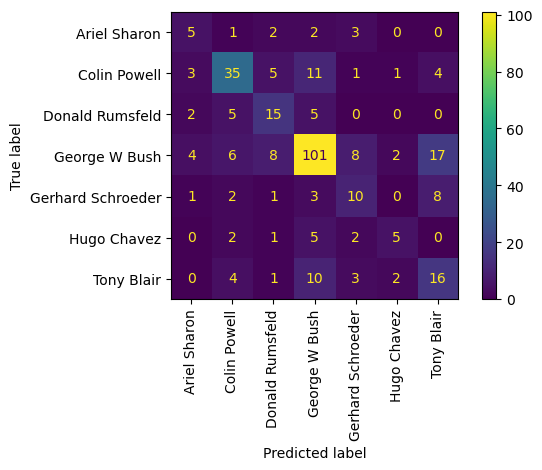

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_pred = pipeline(X_train, X_test, y_train)

report(y_test, y_pred, target_names)


## Reconstruction


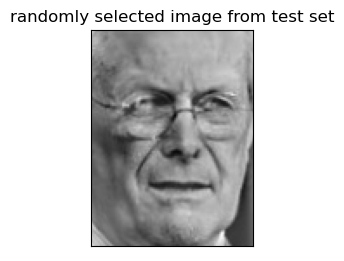

In [11]:
np.random.seed(6)
r = np.random.randint(0, len(X_test))

plot_gallery([X_test[r].reshape(h, w)], [
             "randomly selected image from test set"], n_row=1, n_col=1)


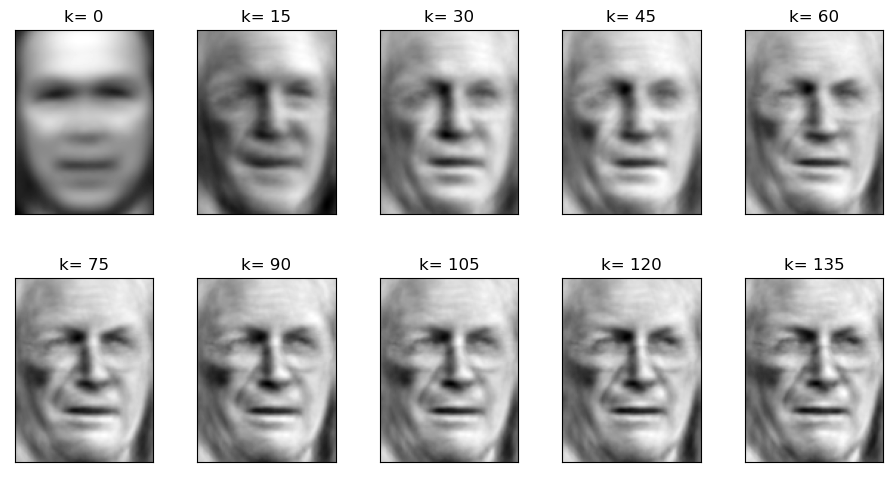

In [12]:

Y = [0]*10
for k, i in zip([0, 15, 30, 45, 60, 75, 90, 105, 120, 135], np.arange(10)):
    face_score = X_test[r, :].dot(eigface[:, :k])
    projected_face = face_score.dot(eigface[:, :k].T)
    Y[i] = projected_face + mean1
    Y[i] = Y[i].reshape(h, w)
plot_gallery(Y, ["k= %d" % j for j in range(0, 150, 15)], n_row=2, n_col=5)


## SVM Classifier


In [13]:
k = 150
print(f"Extracting the top {k} eigenfaces from {len(X_train)} faces")

mean = mean_face(X_train)
eigface, weights = PCA(X_train, mean, k)

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = weights
X_test_pca = project(X_test, mean, eigface)

print("Train PCA shape:", X_train_pca.shape)
print(X_train_pca[0][:20])


Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis
Train PCA shape: (966, 150)
[ 60.504642   43.317184  -22.495934   47.92587    -3.9942837 -21.728317
  15.558213   -4.3678803  10.447307   -3.6829646  13.111273  -22.824255
  15.093719  -30.560614   11.040802  -30.367012   28.065289   -8.002967
 -11.475827   -8.816968 ]


In [14]:
# print("Fitting the classifier to the training set")
# param_grid = {
#     "C": loguniform(1e3, 1e5),
#     "gamma": loguniform(1e-4, 1e-1),
# }
# clf = RandomizedSearchCV(
#     SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
# )
# clf = clf.fit(X_train_pca, y_train)
# print("Best estimator found by random search:")
# print(clf.best_estimator_)

clf = SVC(kernel='linear')
clf.fit(X_train_pca, y_train)


SVC(kernel='linear')

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.81      0.80      0.81        60
  Donald Rumsfeld       0.61      0.70      0.66        27
    George W Bush       0.91      0.87      0.89       146
Gerhard Schroeder       0.69      0.80      0.74        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.85      0.78      0.81        36

         accuracy                           0.81       322
        macro avg       0.74      0.76      0.75       322
     weighted avg       0.82      0.81      0.81       322



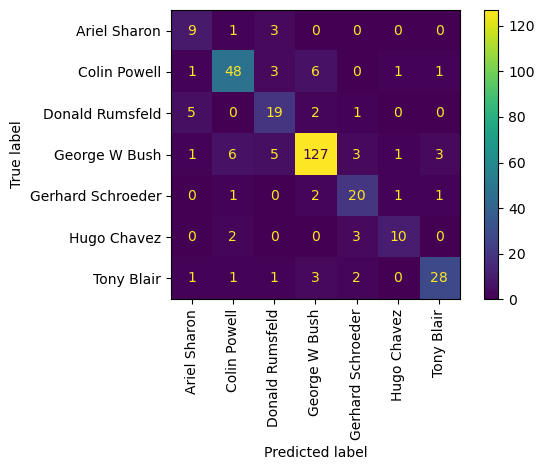

In [15]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)
report(y_test, y_pred, target_names)


In [16]:
# # calculate the projection distance of each image
# def get_proj_distance(X, mean, eigface):
#     proj = project(X, mean, eigface)
#     if len(proj.shape) == 1:
#         proj = proj.reshape(1, -1)
#     sub = X - mean
#     dists = [LA.norm((sub)[i] - np.dot(proj, eigface.T)[i]) for i in range(len(X))]
#     return np.array(dists)

# # determine whether the image is a face by comparing the projection distance with a given threshold
# def is_face(X, mean, eigface, threshold=42367.336):
#     dists = get_proj_distance(X, mean, eigface)
#     print(dists)
#     return dists < threshold

# is_face(X, mean, eigface)


## Distance Plot


In [17]:
a = [y_test == y_pred]
a = np.array(a)
a = a.reshape(y_test.shape[0],)

b = [0 if x == False else 1 for x in a]
c = [i for i, j in enumerate(b) if j == 0]
# c is the array which stores the idx of misidentified images


In [18]:
d = X_test[c]
mean = mean_face(X_train)
# Compute eigenfaces and weights
eigface, weights = PCA(X_train, mean, k)
proj1 = project(d, mean, eigface)
# Compute Euclidean distance
dist1 = euclidean(proj1, weights)


In [19]:
u = np.argmin(dist1, axis=1)
y_train[u]
m = []
for i in range(np.shape(c)[0]):
    m.append(dist1[i, u[i]])
np.mean(m)  # m stores the distance of misidentified images


82.3277

In [20]:
c1 = [i for i, j in enumerate(b) if j == 1]


In [21]:
d1 = X_test[c1]
mean = mean_face(X_train)
# Compute eigenfaces and weights
eigface, weights = PCA(X_train, mean, k)
proj2 = project(d1, mean, eigface)
# Compute Euclidean distance
dist2 = euclidean(proj2, weights)


In [22]:
u = np.argmin(dist2, axis=1)
y_train[u]
m1 = []
for i in range(np.shape(c1)[0]):
    m1.append(dist2[i, u[i]])
np.mean(m1)  # m stores the distance of misidentified images


69.868965

In [23]:
max(m1)


143.14505

Text(0, 0.5, 'shortest distance to training set images')

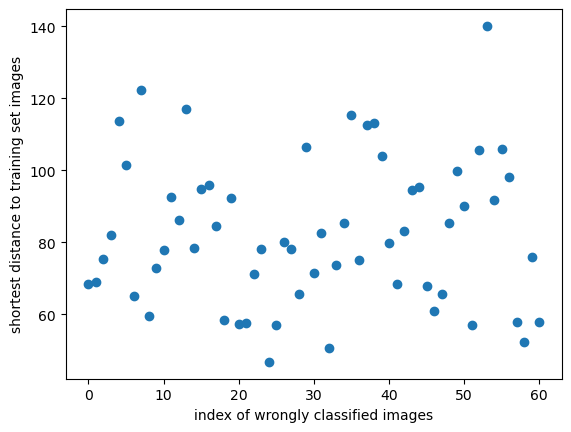

In [24]:
o = range(np.shape(m)[0])
o = np.array(o)
m = np.array(m)
plt.scatter(o, m)
plt.xlabel('index of wrongly classified images')
plt.ylabel('shortest distance to training set images')


Text(0, 0.5, 'shortest distance to training set images')

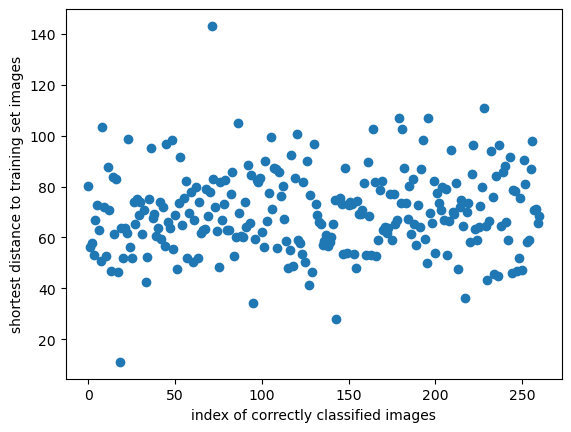

In [25]:
o = range(np.shape(m1)[0])
o = np.array(o)
m1 = np.array(m1)
plt.scatter(o, m1)
plt.xlabel('index of correctly classified images')
plt.ylabel('shortest distance to training set images')


# CSA


In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from csa import *

X = lfw_people.data
scaler = StandardScaler()
X = scaler.fit_transform(X)
mean = mean_face(X)
sha = lfw_people.images.shape
X = (X-mean).reshape(sha)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

m1 = 15
m2 = 10
U1, U2, status = CSA(X_train, m1, m2)

X_train_csa = np.zeros((X_train.shape[0], m1*m2))
for i in range(X_train.shape[0]):
    X_train_csa[i] = np.dot(np.dot(U1.T, X_train[i]), U2).flatten()


X_test_csa = np.zeros((X_test.shape[0], m1*m2))
for i in range(X_test.shape[0]):
    X_test_csa[i] = np.dot(np.dot(U1.T, X_test[i]), U2).flatten()

lda = LinearDiscriminantAnalysis(n_components=5)
lda.fit(X_train_csa, y_train)

X_test_lda = lda.transform(X_test_csa)
X_train_lda = lda.transform(X_train_csa)


                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.62      0.53        13
     Colin Powell       0.78      0.85      0.82        60
  Donald Rumsfeld       0.51      0.70      0.59        27
    George W Bush       0.94      0.82      0.88       146
Gerhard Schroeder       0.75      0.84      0.79        25
      Hugo Chavez       0.85      0.73      0.79        15
       Tony Blair       0.77      0.75      0.76        36

         accuracy                           0.80       322
        macro avg       0.73      0.76      0.74       322
     weighted avg       0.82      0.80      0.81       322



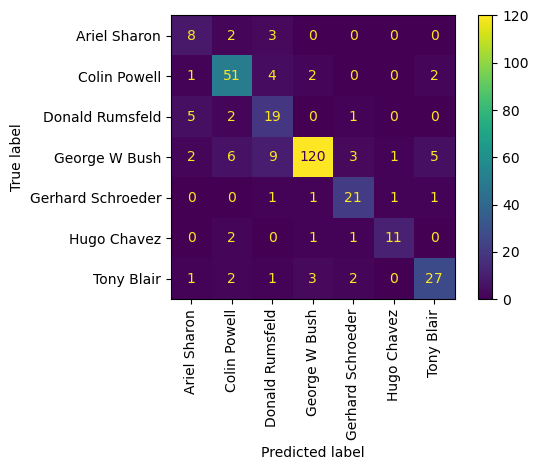

In [27]:
# CSA+SVM

clf2 = SVC(kernel='linear')
clf2.fit(X_train_csa, y_train)

# Make predictions on the test data
y_pred_2 = clf2.predict(X_test_csa)

# Compute the accuracy of the classifier
report(y_test, y_pred_2, target_names)


                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.69      0.58        13
     Colin Powell       0.77      0.85      0.81        60
  Donald Rumsfeld       0.68      0.78      0.72        27
    George W Bush       0.95      0.86      0.90       146
Gerhard Schroeder       0.74      0.80      0.77        25
      Hugo Chavez       1.00      0.73      0.85        15
       Tony Blair       0.78      0.78      0.78        36

         accuracy                           0.83       322
        macro avg       0.77      0.78      0.77       322
     weighted avg       0.84      0.83      0.83       322



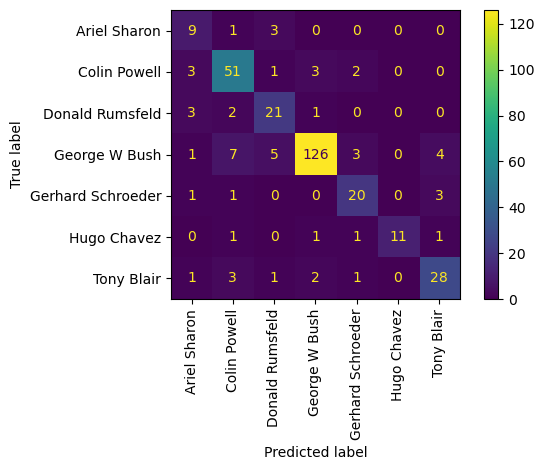

In [28]:
# CSA+LDA+SVM

clf = SVC(kernel='linear')
clf.fit(X_train_lda, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_lda)

# Compute the accuracy of the classifier
report(y_test, y_pred, target_names)


                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.23      0.23        13
     Colin Powell       0.62      0.65      0.63        60
  Donald Rumsfeld       0.43      0.56      0.48        27
    George W Bush       0.77      0.68      0.72       146
Gerhard Schroeder       0.33      0.36      0.35        25
      Hugo Chavez       0.55      0.40      0.46        15
       Tony Blair       0.41      0.50      0.45        36

         accuracy                           0.59       322
        macro avg       0.48      0.48      0.48       322
     weighted avg       0.61      0.59      0.59       322



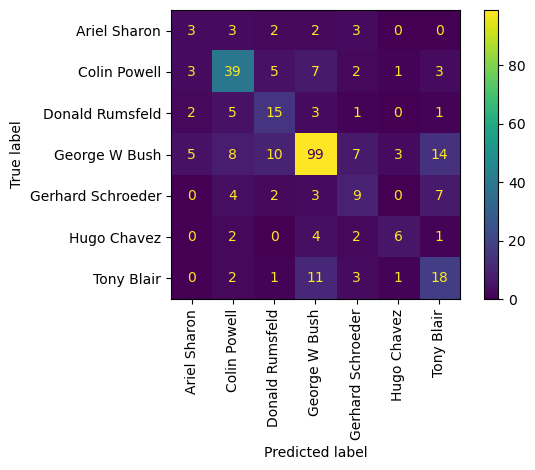

In [29]:
# CSA+EUD

dist = euclidean(X_test_csa, X_train_csa)
# Find the smallest distance of each dev image
idx = np.argmin(dist, axis=1)
# Get the predicted labels
y_pred = y_train[idx]

report(y_test, y_pred, target_names)


                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.69      0.56        13
     Colin Powell       0.75      0.82      0.78        60
  Donald Rumsfeld       0.77      0.74      0.75        27
    George W Bush       0.91      0.85      0.88       146
Gerhard Schroeder       0.60      0.60      0.60        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.68      0.72      0.70        36

         accuracy                           0.78       322
        macro avg       0.71      0.72      0.71       322
     weighted avg       0.79      0.78      0.79       322



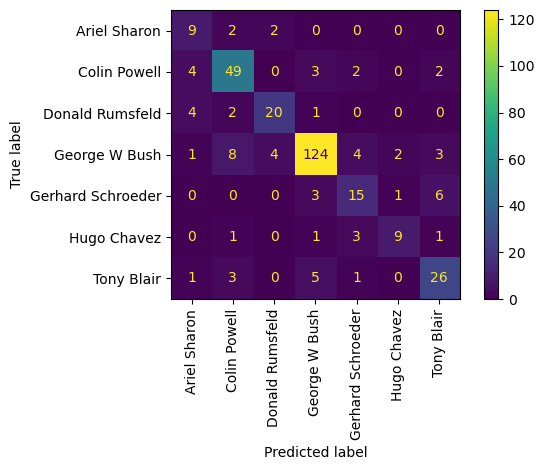

In [30]:
# CSA+LDA+EUD

dist = euclidean(X_test_lda, X_train_lda)
# Find the smallest distance of each dev image
idx = np.argmin(dist, axis=1)
# Get the predicted labels
y_pred = y_train[idx]

report(y_test, y_pred, target_names)


# Fisherfaces, LDA


In [31]:
# from lda import lda


In [32]:
# k = 6
# # Transform the data using LDA
# X_train_lda, W = lda(X_train, y_train, 6)
# X_test_lda = np.dot(X_test, W)

# clf = SVC(kernel='linear')
# clf.fit(X_train_lda, y_train)

# # Make predictions on the test data
# y_pred = clf.predict(X_test_lda)

# # Compute the accuracy of the classifier
# report(y_test, y_pred, target_names)
